# Final Analysis and Cascading Kalman Filter Design

In [1]:
%matplotlib ipympl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import sympy as sp

In [2]:
# Auto reload changed mods.
%load_ext autoreload
%autoreload 2

In [3]:
# Add srcs mods to nbs.
from importlib.util import find_spec
if find_spec("analysis") is None:
    import sys
    print("appending kalman path ...")
    sys.path.append("../kalman")

appending kalman path ...


In [13]:
stat_acc_csv_path = "../data/stationary_acc.csv"
stat_gyr_csv_path = "../data/stationary_gyr.csv"
traj_acc_csv_path = "../data/traj_acc.csv"
traj_gyr_csv_path = "../data/traj_gyr.csv"
traj_gps_csv_path = "../data/traj_gps.csv"
traj_truth_csv_path = "../data/traj_truth.csv"

In [23]:
stat_acc_df = pd.read_csv(stat_acc_csv_path)
stat_gyr_df = pd.read_csv(stat_gyr_csv_path)
traj_acc_df = pd.read_csv(traj_acc_csv_path)
traj_gyr_df = pd.read_csv(traj_gyr_csv_path)
traj_gps_df = pd.read_csv(traj_gps_csv_path)
traj_truth_df = pd.read_csv(traj_truth_csv_path)

In [50]:
from analysis.allanvar import analyse_acc_with_allan, analyse_gyr_with_allan
from analysis.bias import find_acc_bias_model, find_gyr_bias_model
from gps.gps import plot_lat_lon_gps_traj, process_gps_into_enu, find_acc_gyr_sampling_properties, process_all_data_into_df_stream
from filter.kf import DiscreteKF, DiscreteEKF

# Allanvariance Analysis of IMU Sensor

References:
- https://en.wikipedia.org/wiki/Allan_variance
- https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html

## Accelerometer White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Accelerometer's yaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

Sampling properties: 0.05s, 20.0Hz
White-noise Slope: -0.4983117270444709


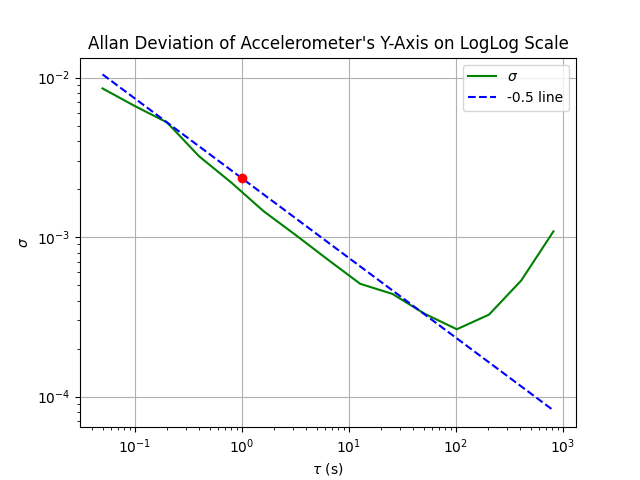

In [21]:
analyse_acc_with_allan(stat_acc_csv_path)

> As seen the white noise is approximately Gaussian.

## Gyro White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Gyro's zaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

Sampling properties: 0.05s, 20.0Hz
White-noise Slope: -0.5019260375250464


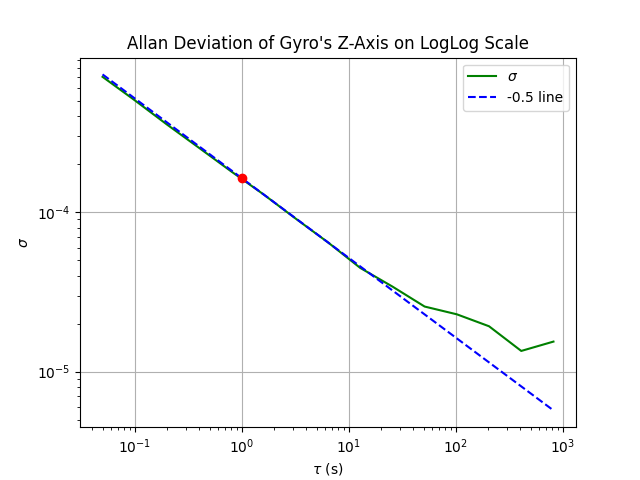

In [22]:
analyse_gyr_with_allan(stat_gyr_csv_path)

> As seen the white noise is approximately Gaussian.


# Bias Classification using Linear Regression

References:
- https://en.wikipedia.org/wiki/Linear_regression
- https://en.wikipedia.org/wiki/Least_squares

## Accelerometer Bias Model

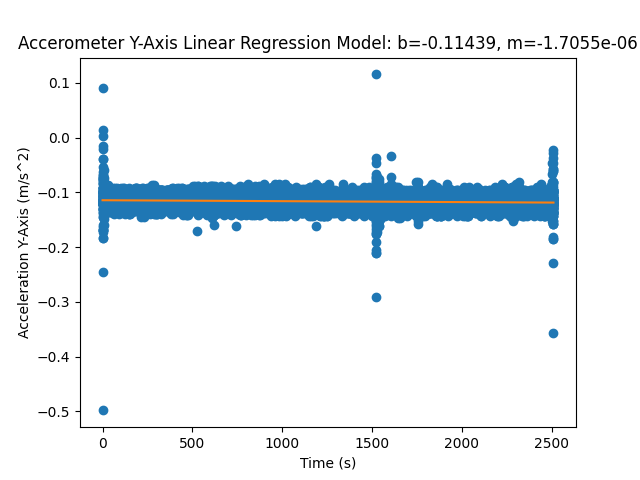

Initial bias (b): -0.11439193955665476
Time-varying bias (b): -1.7055461301349091e-06


In [26]:
acc_yaxis_bias = find_acc_bias_model(stat_acc_csv_path)

## Gyro Bias Model

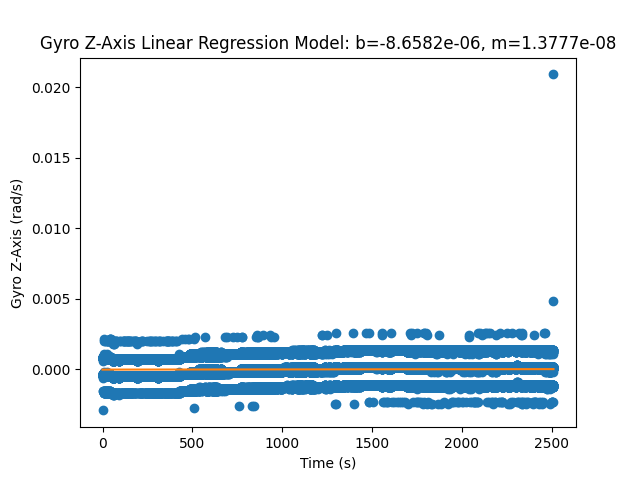

Initial bias (b): -8.658192402998033e-06
Time-varying bias (b): 1.3776831294804729e-08


In [27]:
gyr_zaxis_bias = find_gyr_bias_model(stat_gyr_csv_path)

## Accelerometer Noise Expected Value and Variance

In [30]:
stat_acc_df.describe()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.244651,0.076074,-0.116533,9.757696
std,724.697275,0.007860,0.009195,0.011075
min,0.069651,-0.141775,-0.498305,9.490533
25%,627.657151,0.071186,-0.123230,9.751350
50%,1255.244651,0.075972,-0.116650,9.757333
75%,1882.832151,0.080758,-0.110668,9.766306
max,2510.419651,0.185444,0.115454,10.130613


In [32]:
stat_acc_yaxis_vec = stat_acc_df.loc[:, "Acceleration y (m/s^2)"].to_numpy()
print(f"ACC Biased Mean: {np.mean(stat_acc_yaxis_vec)}, ACC Biased Var: {np.var(stat_acc_yaxis_vec)}")
print(f"ACC Non-Biased Mean: {np.mean(stat_acc_yaxis_vec - acc_yaxis_bias)}, ACC Non-Biased Var: {np.var(stat_acc_yaxis_vec - acc_yaxis_bias)}")

ACC Biased Mean: -0.11653281721361536, ACC Biased Var: 8.455227340409606e-05
ACC Non-Biased Mean: -8.437960336822468e-15, ACC Non-Biased Var: 8.302459638044139e-05


> Non-Biased Noise Mean: $$E[\nu(t)] = -8.43796e^{-15}$$

> Noise Var: $$E[\nu^2(t)] = 8.30246e^{-5}$$

## Gyro Noise Expected Value and Variance

In [33]:
stat_gyr_df.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.259551,-0.000013,0.000007,0.000009
std,724.697275,0.002788,0.001189,0.000714
min,0.084551,-0.357814,-0.092546,-0.002902
25%,627.672051,-0.000458,-0.000764,-0.000305
50%,1255.259551,-0.000305,0.000305,-0.000000
75%,1882.847051,0.000916,0.000458,0.000153
max,2510.434551,0.460440,0.063683,0.020922


In [34]:
stat_gyr_zaxis_vec = stat_gyr_df.loc[:, "Gyroscope z (rad/s)"].to_numpy()
print(f"GYR Biased Mean: {np.mean(stat_gyr_zaxis_vec)}, GRY Biased Var: {np.var(stat_gyr_zaxis_vec)}")
print(f"GYR Non-Biased Mean: {np.mean(stat_gyr_zaxis_vec - gyr_zaxis_bias)}, GRY Non-Biased Var: {np.var(stat_gyr_zaxis_vec - gyr_zaxis_bias)}")

GYR Biased Mean: 8.635306662878425e-06, GRY Biased Var: 5.102994014769565e-07
GYR Non-Biased Mean: 2.9351543326000184e-18, GRY Non-Biased Var: 5.10199722565478e-07


> Non-Biased Noise Mean: $$E[\nu(t)] = 2.93515e^{-18}$$

> Noise Var: $$E[\nu^2(t)] = 5.101997e^{-7}$$

# GPS Analysis and Preprocessing

References:
- https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
- https://proj.org/en/stable/about.html
- https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates
- https://en.wikipedia.org/wiki/Geodetic_coordinates
- https://en.wikipedia.org/wiki/World_Geodetic_System

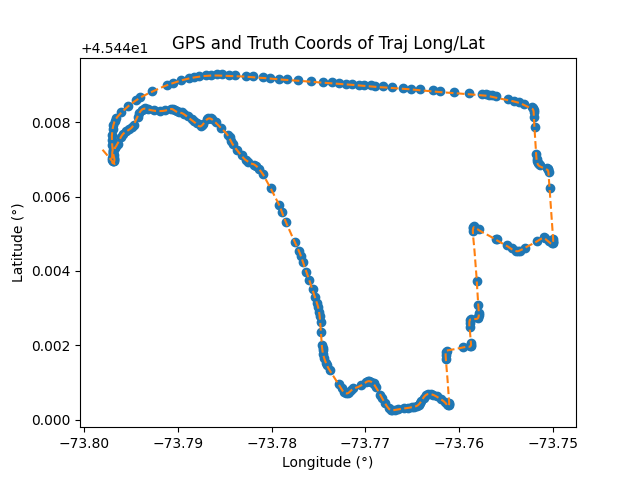

In [40]:
plot_lat_lon_gps_traj(traj_gps_csv_path, traj_truth_csv_path)

## Preprocessing GPS Data to Local Coordinates

First step would be to convert GPS long/lat measurements to relative xy-coords in meters.

Since IMU is in ENU coords the conversion method is as follows:
- Convert geodetic coords to ECEF coords
- Convert ECEF coords to local ENU coords 

The Prime Vertical Radius of Curvature is
$$\frac{a^2}{\sqrt{a^2\cos^2\phi + b^2\sin^2\phi}},$$
where $a = 6378137.0m$ and $b = 6356752.314245 m$ are the semi-major axis and semi-minor axis, respectively. $\phi$ is geodetic latitude and $\lambda$ is geodetic longitude.

In [38]:
traj_gps_enu_vec = process_gps_into_enu(traj_gps_csv_path)

Text(0, 0.5, 'y (m)')

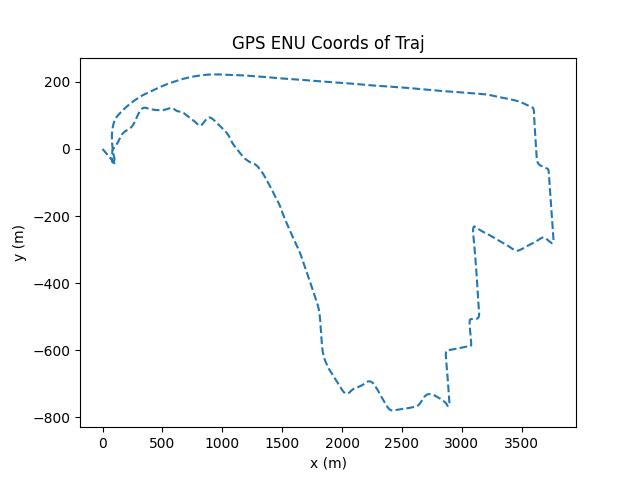

In [60]:
plt.figure()
plt.plot(traj_gps_enu_vec[:, 0], traj_gps_enu_vec[:, 1], '--')
plt.title("GPS ENU Coords of Traj")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

## Finding Properties of Data and Sequencing 

In [43]:
T_acc, Fs_acc, T_gyr, Fs_gyr = find_acc_gyr_sampling_properties(traj_acc_csv_path, traj_gyr_csv_path)

Sampling properties (ACCEL): 0.002100000000000001s, 476.1904761904759Hz
Sampling properties (GYRO): 0.0022000000000000006s, 454.54545454545445Hz


In [45]:
data_seq_df = process_all_data_into_df_stream(traj_acc_csv_path, traj_gyr_csv_path, traj_gps_csv_path)

ACC: 372578, GYR: 372574, GPS: 791 data points each


In [46]:
data_seq_df.head(20)

,Time (s),Measurement,Type
0,0.0000,-1.067956,GPS_THETA
1,0.0000,0.000000,GPS_VEL
2,0.0000,0.000000,GPS_X
3,0.0000,0.000000,GPS_Y
4,0.0000,0.000000,GPS_Z
5,0.0225,-0.282000,ACCEL
6,0.0246,-0.282000,ACCEL
7,0.0267,-0.277000,ACCEL
8,0.0289,-0.191000,ACCEL
9,0.0310,-0.153000,ACCEL


In [53]:
ACCEL_TYPE = "ACCEL"
GYRO_TYPE = "GYRO"
GPS_VEL_TYPE = "GPS_VEL"
GPS_THETA_TYPE = "GPS_THETA"
GPS_X_TYPE = "GPS_X"
GPS_Y_TYPE = "GPS_Y"
GPS_Z_TYPE = "GPS_Z"

# Cascading Kalman Filter Implementation

References:
- https://www.mathworks.com/help/fusion/ug/pose-estimation-from-asynchronous-sensors.html
- https://ardupilot.org/dev/docs/extended-kalman-filter.html

## Fuse GPS and INS Vel/Heading Measurements

State vector:

$$
x = \left(\begin{matrix}
  v \\
  \theta 
\end{matrix}\right)
$$

IMU Dynamics Equations:

$$
\begin{align}
\dot{v}(t) &= a(t) + b_a(t) + \nu_a(t) \\
\dot{\theta}(t) &= \omega(t) + b_{\omega}(t) + \nu_{\omega}(t),
\end{align}
$$
where $$u(t) = \left[a_m(t), \omega_m(t) \right]^T$$

GPS Measurement Equations:

$$
\begin{align}
v(t) &= v(t) + \nu_{GPS}(t) \\
\theta(t) &= \theta(t) + \nu_{GPS}(t)
\end{align}

Thus,

$$
A_c = \left(\begin{matrix}
  0 & 0 \\
  0 & 0 
\end{matrix}\right)
 $$

$$
B_c = \left(\begin{matrix}
  1 & 0 \\
  0 & 1 
\end{matrix}\right)
 $$

$$
H_k = \left(\begin{matrix}
  1 & 0 \\
  0 & 1
\end{matrix}\right)
$$

Discritizing using Euler Forward method:

$$
A_k = \left(\begin{matrix}
  1 & 0 \\
  0 & 1 
\end{matrix}\right)
 $$

$$
B_k = \left(\begin{matrix}
  T & 0 \\
  0 & T 
\end{matrix}\right)
 $$

$$
H_k = \left(\begin{matrix}
  1 & 0 \\
  0 & 1
\end{matrix}\right)
$$
where $T$ is the sampling rate of the IMU sensor.

Determining $Q_k$ and $R_k$ based on given $Q(t)$ and $R_k$:

$$
Q(k) = E\left[B_kw(k)\left(B_kw(k)\right)^T\right] = B_kE\left[w(k)w^T(k)\right]B_k^T,
$$
where $E\left[w(k)w^T(k)\right]$ is just the covariance of the process noise introduced by the inputs $\sigma_{\eta}^2$.

So, 
$$
Q_k = \left(\begin{matrix}
  12.5T^2 & 0 \\
  0 & 0.001T^2 
\end{matrix}\right),
$$
based on the given values $Var\left[\nu_a\right] = 12.5m^2/s^4$ and $Var\left[\nu_{\omega}\right] = 0.001 rad^2/s^2$, 

Here, assume 
$$
R_k = \left(\begin{matrix}
  0.06 & 0 \\
  0 & 0.06 
\end{matrix}\right)

$$



> Usually these two parameters $Q_k$ and $R_k$ have to get tuned.

## Fusing Process Model and GPS and Everything in Between

Below there is the design of a cascading KF-EKF filter. The low-level KF filter estimates heading ($\theta(t)$) and velocity $v(t)$. The high-level EKF filter estimates the vehicles $XY$ coordinates by fusing INS equtions for the vehicle which is nonlinear and the measurements of the GPS in ENU coords. The EKF takes as input the heading and velocity estimates outputted by KF filter in a cascading fashion.

The primary difference between an EKF and KF filter is the use of the nonlinear process and measurement models $f(x, u)$ and $h(x)$, respectively during the predict phase, and the use of Jacobians $A_k = \frac{\partial{f}}{\partial{x}}$ and $H_k = \frac{\partial{h}}{\partial{x}}$ in the KF predict and correct phase, respectively.


Let the state vector be,
$$
x = \left(\begin{matrix}
  p_x \\
  p_y 
\end{matrix}\right)
$$

The process model is as follows:
$$
\begin{align}
\dot{p}_x(t) &= v(t)\cos(\theta(t)) \\
\dot{p}_y(t) &= v(t)\sin(\theta(t)),
\end{align}
$$

## Run Cascading EKF with Biased Gyro/Accel

Assumptions:
- Initial conditions have unit variance I for both filters

> Note since Jacobian $A_k$ results in zero matrix, discritizing using Euler Forward results in the same $A_k$ matrix as in KF case. So the only difference between EKF version and KF version is the use of the nonlinear model during the prediction phase. The measurement model $h$ is linear so EKF returns the same KF corrections.

In [47]:
# KF params.
A_k_kf = np.array([[1, 0],
                [0, 1]])
B_k_kf = np.array([[T_acc, 0],
                [0, T_gyr]])
H_k_kf = np.array([[1, 0],
                [0, 1]
                ])

In [48]:
# KF/EKF noise covariances.
Q_k = np.array([[12.5*T_acc**2, 0],
                [0, 0.001*T_gyr**2]])
R_k = np.array([[0.06, 0],
                [0, 0.06]])

In [49]:
# EKF params.
A_k_ekf = lambda x, u: np.array([[1, 0],
                                 [0, 1]])
H_k_ekf = lambda x: np.array([[1, 0],
                              [0, 1]
                              ])
f = lambda x, u: np.array([u[0]*np.cos(u[1]), u[0]*np.sin(u[1])]).reshape((2, 1))
h = lambda x: H_k_ekf(None) @ x

In [51]:
#  Instantiate KF/EKF.
heading_speed_kf = DiscreteKF(A_k_kf, B_k_kf, H_k_kf, Q_k, R_k)
xy_ekf = DiscreteEKF(f, h, A_k_ekf, H_k_ekf, Q_k, R_k)

In [52]:
# Init filters with I.C.
x0_kf = np.array([0, np.deg2rad(28.8)]).reshape((2, 1))
P0_kf = np.eye(2)
x0_ekf = np.array([0, 0]).reshape((2, 1))
P0_ekf = np.eye(2)
heading_speed_kf.init_filter(x0_kf, P0_kf)
xy_ekf.init_filter(x0_ekf, P0_ekf)

In [54]:
# Filter loop.
pred_vel_log = []
pred_theta_log = []
pred_x_log = []
pred_y_log = []
time_log = []
for i, row in data_seq_df.iterrows():
    t, zk, typ = row

    if (typ == GPS_VEL_TYPE):
        continue
    elif (typ == GPS_X_TYPE):
        continue
    elif (typ == GPS_Y_TYPE):
        continue
    elif (typ == GPS_Z_TYPE):
        continue

    pred_kf = heading_speed_kf.get_state_estim()
    pred_ekf = xy_ekf.get_state_estim()
    pred_vel_log.append(pred_kf[0])
    pred_theta_log.append(pred_kf[1])
    pred_x_log.append(pred_ekf[0])
    pred_y_log.append(pred_ekf[1])
    time_log.append(t)

    if (typ == ACCEL_TYPE):
        uk = np.array([zk, 0]).reshape((2, 1))
        heading_speed_kf.predict(uk)

    elif (typ == GYRO_TYPE):
        uk = np.array([0, zk]).reshape((2, 1))
        heading_speed_kf.predict(uk)

    # Make prediction anytime IMU gets activated.
    if (typ == ACCEL_TYPE or typ == GYRO_TYPE):
        uk = heading_speed_kf.get_state_estim()
        xy_ekf.predict(uk)

    elif (typ == GPS_THETA_TYPE):
        assert data_seq_df.iloc[i]['Type'] == GPS_THETA_TYPE
        assert data_seq_df.iloc[i+1]['Type'] == GPS_VEL_TYPE
        assert data_seq_df.iloc[i+2]['Type'] == GPS_X_TYPE
        assert data_seq_df.iloc[i+3]['Type'] == GPS_Y_TYPE
        assert data_seq_df.iloc[i+4]['Type'] == GPS_Z_TYPE

        yk_theta = data_seq_df.iloc[i]['Measurement']
        yk_vel = data_seq_df.iloc[i+1]['Measurement']
        yk_x = data_seq_df.iloc[i+2]['Measurement']
        yk_y = data_seq_df.iloc[i+3]['Measurement']
        yk_z = data_seq_df.iloc[i+4]['Measurement']
        zk = np.array([yk_vel, yk_theta]).reshape(2, 1)
        heading_speed_kf.correct(zk)

        zk = np.array([yk_x, yk_y]).reshape(2, 1)
        xy_ekf.correct(zk)

## Plot ALL Biased Results

In [68]:
traj_acc_yaxis_vec = traj_acc_df.loc[:, "Acceleration y (m/s^2)"].to_numpy()
traj_acc_time_vec = traj_acc_df.loc[:, "Time (s)"].to_numpy()
traj_gyr_zaxis_vec = traj_gyr_df.loc[:, "Gyroscope z (rad/s)"].to_numpy()
traj_gyr_time_vec = traj_gyr_df.loc[:, "Time (s)"].to_numpy()
traj_gps_vel_vec = traj_gps_df.loc[:, "Velocity (m/s)"].to_numpy()
traj_gps_theta_vec = -np.deg2rad(traj_gps_df.loc[:, "Direction (°)"].to_numpy())
traj_gps_time_vec = traj_gps_df.loc[:, "Time (s)"].to_numpy()

In [56]:
# Forward euler integrate to get raw ins data.
vel_cum = np.cumsum(traj_acc_yaxis_vec)*T_acc
theta_cum = np.cumsum(traj_gyr_zaxis_vec)*T_gyr
assert vel_cum.shape == traj_acc_time_vec.shape
assert theta_cum.shape == traj_gyr_time_vec.shape
raw_ins = np.stack((vel_cum[0: -4], theta_cum), axis=1)

In [57]:
# Apply dynamics model to get raw xy coords.
raw_xy = np.apply_along_axis(lambda row: np.array([row[0]*np.cos(row[1]), row[0]*np.sin(row[1])]), 1, raw_ins)

/var/folders/y4/9flb_gwd6vzf86ds_bx5ydkc0000gn/T/ipykernel_18956/4042017359.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


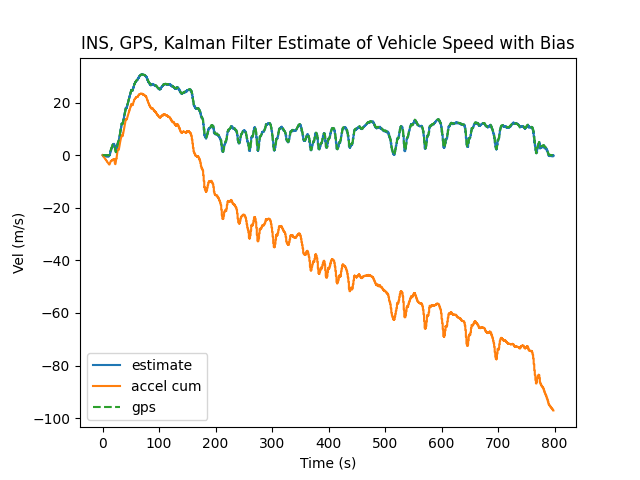

In [62]:
# Plot INS, GPS, Kalman Filter estimate of vehicle speed over time.
plt.figure()
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle Speed with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Vel (m/s)")
plt.plot(time_log, pred_vel_log, label="estimate")
plt.plot(traj_acc_time_vec, vel_cum, label="accel cum")
plt.plot(traj_gps_time_vec, traj_gps_vel_vec, "--", label="gps")
plt.legend()

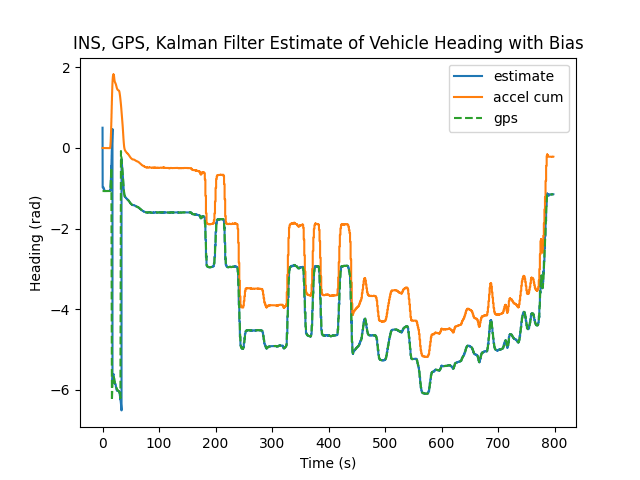

In [69]:
# Plot INS, GPS, Kalman Filter estimate of vehicle heading over time.
plt.figure()
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle Heading with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Heading (rad)")
plt.plot(time_log, pred_theta_log, label="estimate")
plt.plot(traj_gyr_time_vec, theta_cum, label="accel cum")
plt.plot(traj_gps_time_vec, traj_gps_theta_vec, "--", label="gps")
plt.legend()

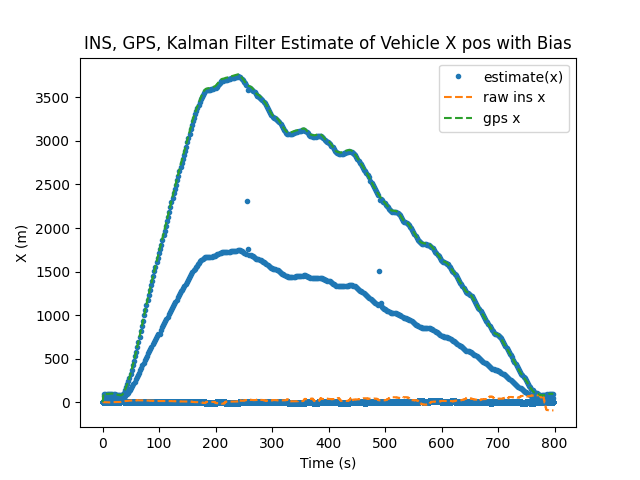

In [70]:
# Plot INS, GPS, Kalman Filter estimate of vehicle xy pos over time.
plt.figure()
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle X pos with Bias")
plt.xlabel("Time (s)")
plt.ylabel("X (m)")
plt.plot(time_log, pred_x_log, ".", label="estimate(x)")
plt.plot(traj_gyr_time_vec, raw_xy[:, 0], "--", label="raw ins x")
plt.plot(traj_gps_time_vec, traj_gps_enu_vec[:, 0], "--", label="gps x")
plt.legend()

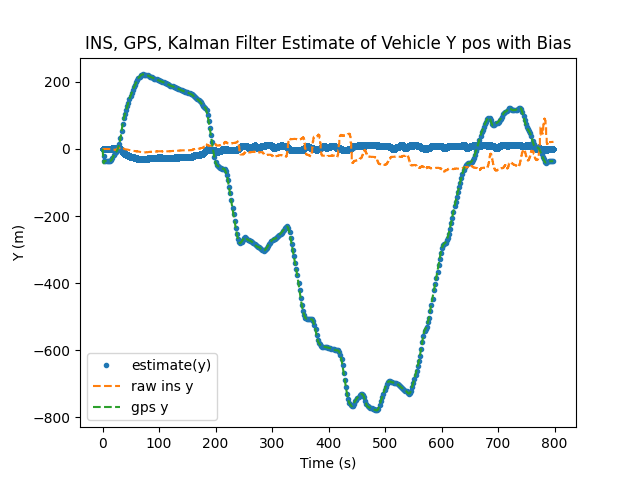

In [71]:
# Plot INS, GPS, Kalman Filter estimate of vehicle xy pos over time.
plt.figure()
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle Y pos with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Y (m)")
plt.plot(time_log, pred_y_log, ".", label="estimate(y)")
plt.plot(traj_gyr_time_vec, raw_xy[:, 1], "--", label="raw ins y")
plt.plot(traj_gps_time_vec, traj_gps_enu_vec[:, 1], "--", label="gps y")
plt.legend()

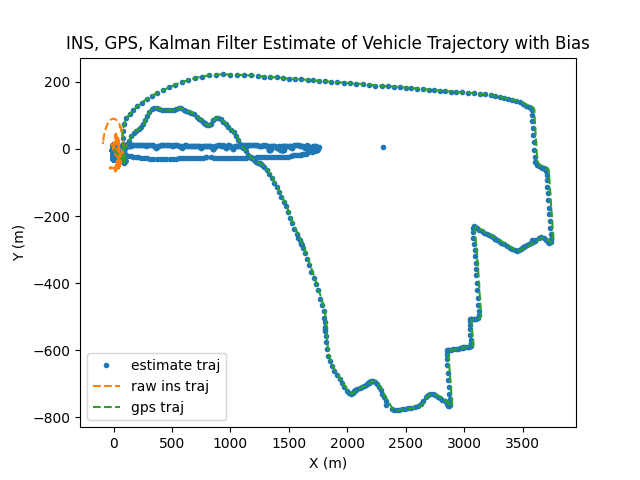

In [72]:
# Plot INS, GPS, Kalman Filter estimate of vehicle xy pos over time.
plt.figure()
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle Trajectory with Bias")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.plot(pred_x_log, pred_y_log, ".", label="estimate traj")
plt.plot(raw_xy[:, 0], raw_xy[:, 1], "--", label="raw ins traj")
plt.plot(traj_gps_enu_vec[:, 0], traj_gps_enu_vec[:, 1], "--", label="gps traj")
plt.legend()